In [1]:
# Tristan Wellman, BCB group, National Phenology Network project
# Purpose: Explores basic netcdf processing, data processing, and visualization
#          Sets up and compares realtime (on the fly) plotting vs preprocessed plotting
#          
# Status: working draft, requires additional modification and QA/QC prior to external distribution
# Update date: Nov 30, 2016
#
# Input specifications (specs in cell below): 
#    (a) set working directory
#    (b) specify local netcdf file time series file

# operations:
#    (a) reads a netcdf time series file from NPN Geoserver
#    (b) process netcdf data slices as numpy masked arrays
#    (c) creates a customized time series box plot
#    (d) creates a customized deviation from historical trend (median) bar plots
#    (e) creates a frequency histogram of results
#    (f) creates a key, value dictionary of plot specification for preprocessing (in progress), 
#    (g) creates altered plot functions to use preprocessed plot specfications
#    (h) produces realtime generated plots and plots generated using preprocessed information 

In [2]:
#!/usr/bin/env python

import json
import netCDF4
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 
import matplotlib.cbook as cbook
%matplotlib inline
import datetime
from timeit import default_timer as timer

print 'loaded libraries'

loaded libraries


In [3]:
# working directory, netcdf file path
workdir = '/Users/twellman/Documents/BCB_data_projects/NPN_BCB/'
file_src = '{}{}'.format(workdir,'si-x-average_leaf_prism.nc')
file_src 


'/Users/twellman/Documents/BCB_data_projects/NPN_BCB/si-x-average_leaf_prism.nc'

In [4]:
# *******************************************
# Load netcdf data file + initial processing
# *******************************************

# simple task + time accounting
tstamp = []
tasklist = []
tasklist.append('Load netcdf data, slice data, patch for data masking')
tstamp.append(timer())

# netcdf - query variable keys and restructure data array
nc_file = netCDF4.Dataset(file_src)
key = nc_file.variables.keys()

# numpy datasets
data = nc_file.variables[key[3]][:,:,:] 
d_mod = [d[~d.mask] for d in data]  
cpy = np.reshape(data, (np.product(data.shape),))
d_mod2 = []
d_mod2.append(cpy[~cpy.mask])

print ('Data type:\n\t%s\nVariables:\n\t%s\n\nData slice variable:\n\t%s\n\nVariable information:\n%s\n'
       'Data slice file dimensions (calc): %s\n' % (type(data), key, key[3], nc_file.variables[key[3]], data.shape))

Data type:
	<class 'numpy.ma.core.MaskedArray'>
Variables:
	[u'time', u'lat', u'lon', u'six_average_leaf_prism']

Data slice variable:
	six_average_leaf_prism

Variable information:
<type 'netCDF4._netCDF4.Variable'>
int16 six_average_leaf_prism(time, lat, lon)
    units: day
    _FillValue: -9999
unlimited dimensions: 
current shape = (35, 621, 1405)
filling off

Data slice file dimensions (calc): (35, 621, 1405)



In [5]:
type(data)

numpy.ma.core.MaskedArray

In [6]:
# Python definitions for real-time plotting 

tasklist.append('Generate real-time python plotting definitions')
tstamp.append(timer())

def palette_values(data, inc):
    lmin = np.min(data)
    lmax = np.max(data)
    unit = (data - lmin)/(lmax - lmin)
    datanorm = np.multiply(np.rint(np.divide(unit, inc)),inc)
    return datanorm

def makeboxplot(ax,data):
    boxprops = dict(linestyle='-', linewidth=0.75, color='black')
    bp = ax.boxplot(data, boxprops=boxprops, widths = 1.0, patch_artist=True, showmeans=True)
    ax.set_axisbelow(True)
    plt.setp(bp['boxes'], label = "25-75th percentile")
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    for patch, color in zip(bp['boxes'], clr):
        patch.set_facecolor(color)
        patch.set_label("25-75th percentile")
    ax.set_title(title, fontsize=15)
    ax.set_ylabel(ylabeltext, fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.set_xticks(ind)
    ax.set_xticklabels(xlabelsnew)   
    ax.set_xlabel(xlabeltext, fontsize=12) 
    ax.yaxis.set_major_locator(months)
    ax.yaxis.set_major_formatter(monthsFmt)
    plt.setp(bp['whiskers'], color='gray',linestyle ='-', label = "+/- 1.5 IQR" )
    plt.setp(bp['medians'], color='red',linestyle ='-', lw=1.6, label = "median")
    plt.setp(bp['means'], color='yellow', linestyle ='', ms=5, marker='o', markerfacecolor="yellow",label = "mean")
    plt.setp(bp['fliers'], color='white', marker='o', ms=1, markerfacecolor=(0.30,  0.30,  0.20),label = "outlier")
    plt.setp(bp['boxes'], label = "25-75th percentile")
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.autoscale_view()
    ax.set_ylim([1,250])
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[1:5], labels[1:5],loc='center left', bbox_to_anchor=(1, 0.75),
               shadow=True, frameon=True, fontsize=12, framealpha = 1.0, numpoints = 1, borderpad=.2) 
    return
    
def makebarplot_value_errbar(ax, x, y, errbar):
    ax.bar(x, y, width = 1.0, color= clr, align='center', linewidth = 0.75, edgecolor="black")
    ax.set_axisbelow(True)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='both', labelsize=10, color='black', labelcolor='black')
    ax.set_xticks(ind)
    ax.set_xticklabels(xlabelsnew) 
    ax.set_xlabel(xlabeltext, fontsize=10)
    ax.set_ylabel(ylabeltext, fontsize=10)
    (_, caps, _) = ax.errorbar(x, y, errbar, capsize=5, linewidth = 0.0, elinewidth=1.25, ecolor="gray",linestyle ='-')
    for cap in caps:
        cap.set_color('gray')
        cap.set_markeredgewidth(1.25)
    legend = ax.legend(['average','(min, max)'], loc='center left', bbox_to_anchor=(1, 0.75),
                        shadow=True, frameon=True, fontsize=12, framealpha = 1.0, numpoints = 1, borderpad=.3)
    legend.set_zorder(100)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.yaxis.set_major_locator(months)
    ax.yaxis.set_major_formatter(monthsFmt)
    ax.set_ylim([1,250]) 
    ax.autoscale_view()
    return 

def makebarplot_resid(ax, x, y):
    ax.bar(x, y, width = 1.0, color= clr, align='center', linewidth = 0.75, edgecolor="black")
    ax.set_axisbelow(True)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.set_title(title, fontsize=15)
    ax.set_xticks(ind)
    ax.set_xticklabels(xlabelsnew) 
    ax.set_xlabel(xlabeltext, fontsize=12)
    ax.set_ylabel(ylabeltext, fontsize=12)
    legend = ax.legend(['median\ndeviation'],loc='center left', bbox_to_anchor=(1, 0.75),
                        shadow=False, frameon=True, fontsize=12, framealpha = 1.0, numpoints = 1, borderpad=.3) 
    legend.set_zorder(100)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.autoscale_view()
    return

def histogram_freq(ax,nbin):
    weights = np.ones_like(d_mod2)/float(len(d_mod2[0]))
    n, bins, patches = ax.hist(d_mod2, nbin, normed=0, linewidth=0.75, facecolor=(0.5, .95, 0.95), alpha=0.75,weights=weights)
    ax.set_title(title, fontsize=15)
    ax.set_ylabel(ylabeltext, fontsize=12)
    ax.set_xlabel(xlabeltext, fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.autoscale_view()
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.set_axisbelow(True)
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 100))
    ax.yaxis.set_major_formatter(formatter)
    cumulative = np.cumsum(n)
    axx = ax.twinx()
    axx.plot(bins[:-1], cumulative, c='yellow', linewidth=2.0)
    axx.set_ylabel('Cumulative frequency [%]',fontsize=12)
    axx.yaxis.set_major_formatter(formatter)
    ax.set_xlim([1,250])
    ax.plot(np.nan, 'yellow', linewidth=2.0)
    legend = ax.legend(['cumulative','bin'], loc="lower center", bbox_to_anchor=(0.92,0.75), shadow=True, frameon=True, 
                fontsize=12, framealpha = 1.0, numpoints = 1)
    print('Calc check: sum bin (discrete) probability [%]:', np.sum(n)*100.0)
    return

print 'created real-time definitions'

created real-time definitions


In [7]:
# Python definitions for preprocessed plotting 

tasklist.append('Generate preprocessed python plotting definitions')
tstamp.append(timer())

# generate box plot 
def makeboxplot_preprocess(ax, stats, specs):
    boxp = dict(linestyle='-', linewidth=0.75, color ='black', label = "25-75th percentile")
    whiskp = dict(color='gray',linestyle ='-', linewidth=0.75, label = "+/- 1.5 IQR" )
    medp = dict(color='red',linestyle ='-', lw=1.6, label = "median")
    meanptp = dict(color='yellow', linestyle ='', ms=5, marker='o', markerfacecolor="yellow",label = "mean")
    flierp = dict(color='white', marker='o', ms=1, markerfacecolor=(0.30,  0.30,  0.20),label = "outlier")
    bp = ax.bxp(stats, boxprops = boxp, whiskerprops = whiskp, medianprops = medp, meanprops = meanptp, 
            flierprops = flierp, widths = 1.0, patch_artist=True, showmeans=True)
    ax.set_axisbelow(True)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    for patch, color in zip(bp['boxes'], specs['box_clr']):
        patch.set_facecolor(color)
    ax.set_title(specs['title'], fontsize=15)
    ax.set_ylabel(specs['box_axlabels'][1], fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.set_xticks(specs['ind'])
    ax.set_xticklabels(specs['xlabelsnew'])   
    ax.set_xlabel(specs['box_axlabels'][0], fontsize=12) 
    ax.yaxis.set_major_locator(months)
    ax.yaxis.set_major_formatter(monthsFmt)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.autoscale_view()
    ax.set_ylim([1,250])
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[1:5], labels[1:5],loc='center left', bbox_to_anchor=(1, 0.75),
               shadow=True, frameon=True, fontsize=12, framealpha = 1.0, numpoints = 1, borderpad=.2) 
    
# generate bar plot
def makebarplot_resid_preprocess(ax, x, y, specs):
    ax.bar(x, y, width = 1.0, color= specs['bar_clr'], align='center', linewidth = 0.75, edgecolor="black")
    ax.set_axisbelow(True)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.set_title(specs['title'], fontsize=15)
    ax.set_xticks(specs['ind'])
    ax.set_xticklabels(specs['xlabelsnew']) 
    ax.set_xlabel(specs['bar_axlabels'][0], fontsize=12)
    ax.set_ylabel(specs['bar_axlabels'][1], fontsize=12)
    legend = ax.legend(['median\ndeviation'],loc='center left', bbox_to_anchor=(1, 0.75),
                        shadow=True, frameon=True, fontsize=12, framealpha = 1.0, numpoints = 1, borderpad=.3) 
    legend.set_zorder(100)
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.autoscale_view()
    return

# generate histogram
def histogram_freq_preprocess(ax, stats, specs):
    n = stats['n']
    bins = stats['bins']
    ax.bar(bins[:-1], n, width = bins[1]-bins[0], color= (0.5, .95, 0.95), align='center', linewidth = 0.75, edgecolor="black")
    ax.set_title(specs['title'], fontsize=15)
    ax.set_ylabel(specs['hist_axlabels'][1], fontsize=12)
    ax.set_xlabel(specs['hist_axlabels'][0], fontsize=12)
    ax.tick_params(axis='both', labelsize=12, color='black', labelcolor='black')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.grid(True, color='white', linestyle='-', linewidth=0.75)
    ax.autoscale_view()
    ax.set_axis_bgcolor((0.86764706,  0.87941176,  0.89901961))
    ax.set_axisbelow(True)
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 100))
    ax.yaxis.set_major_formatter(formatter)
    cumulative = np.cumsum(n)
    axx = ax.twinx()
    axx.plot(bins[:-1], cumulative, c='yellow', linewidth=2.0)
    plt.ylabel(specs['hist_axlabels'][2],fontsize=12)
    axx.yaxis.set_major_formatter(formatter)
    ax.set_xlim([1,250])
    ax.plot(np.nan, 'yellow', linewidth=2.0)
    legend = ax.legend(['cumulative','bin'], loc="lower center", bbox_to_anchor=(0.92,0.75), shadow=True, frameon=True, 
                fontsize=12, framealpha = 1.0, numpoints = 1)
    print('Calc check: sum bin (discrete) probability [%]:', np.sum(n)*100.0)
    return

print 'created preprocessing definitions'

created preprocessing definitions


In [8]:
# *********************************
#   Pre-processing information
# *********************************

tasklist.append('Generate key-value dictionary of preprocessed plot information')
tstamp.append(timer())

# Functions to generate and store plotting information 
# used to allow preprocessing capabilties
# work in progress ....

tasklist.append('Pre-process plot info + plot calcs')
tstamp.append(timer())
stats = {}

# pre-process time related specifications, simplify labels
time_var = nc_file.variables['time']
dtime = netCDF4.num2date(time_var[:],time_var.units)
dt_year = [d.year for d in dtime] 
ind = np.arange(1,len(dt_year)+1)
minyear = min(dt_year)
maxyear = max(dt_year)
xlabelsnew = []
for i in dt_year:
    if i % 5 == 0:
        xlabelsnew.append(i)
    else:
        xlabelsnew.append('')
stats['plot_specs'] = {}
stats['plot_specs']['ind'] = ind.tolist() 
stats['plot_specs']['xlabelsnew'] = xlabelsnew
stats['plot_specs']['title'] = '%s (%d - %d)' % (str(key[3]).replace("_"," ").title(), minyear, maxyear)
stats['plot_specs']['box_axlabels'] = ('Year', 'Period in year [days]')
stats['plot_specs']['bar_axlabels'] = ('Year','Deviation to historical record\nearly (+) or late (-) [days]')
stats['plot_specs']['hist_axlabels'] = ('Intra-year composite, all data records [days]','Frequency by date bin [%]',
                                       'Cumulative frequency [%]')

# pre-calculate box plot properties as json-like dictionary
stats['box_plot'] = cbook.boxplot_stats(d_mod, labels=None, bootstrap=None)

# pre-calculate and store bar plot median properties
median_year = [np.median(d) for d in d_mod]
median_all = np.median((data[~data.mask]))
diff_median_year = median_all - median_year
errbar_med = np.transpose([median_year[i]-(np.min(d), np.max(d)-median_year[i]) for i,d in enumerate(d_mod)])
stats['bar_plot'] = {}
stats['bar_plot']['med_yr'] = median_year 
stats['bar_plot']['dev_yr'] = diff_median_year.tolist()
stats['bar_plot']['med_errbar'] = errbar_med.tolist()

# pre-determine colormap ranges correlated to medians, deviation from medians
stats['plot_specs']['box_clr'] = cm.GnBu(palette_values(np.multiply(median_year,1.0), 0.05)).tolist()
stats['plot_specs']['bar_clr'] = cm.summer(palette_values(np.multiply(diff_median_year,-1.0), 0.05)).tolist()

# pre-calculate histogram and cumulative frequency properties
nbins = 30
weights = np.ones_like(d_mod2)/float(len(d_mod2[0]))
n, bins, patches = plt.hist(d_mod2, nbins, normed=0,weights=weights)
plt.close()
stats['hist_plot'] = {}
stats['hist_plot']['n'] = n.tolist()
stats['hist_plot']['bins'] = bins.tolist()

# pre-calculate other barplot + misc. properties
stats['bar_plot']['dev_yr'] = np.asarray(stats['bar_plot']['dev_yr'])
stats['bar_plot']['med_errbar']= np.asarray(stats['bar_plot']['med_errbar'])
stats['plot_specs']['box_clr'] = np.asarray(stats['plot_specs']['box_clr'])
stats['plot_specs']['bar_clr'] = np.asarray(stats['plot_specs']['bar_clr'])
#stats['box_plot'] = stats['box_plot'][0]
#stats['bar_plot']['dev_yr']

print ('Generated preprocessed plot information dictionary')


Generated preprocessed plot information dictionary


In [9]:
tasklist.append('display key-value dictionary')
tstamp.append(timer())

print('Preprocesed information dictionary to generate plots'
      '\nStatus: twellman, incomplete, work in progress\n')
stats

Preprocesed information dictionary to generate plots
Status: twellman, incomplete, work in progress



{'bar_plot': {'dev_yr': array([ -1.,  -6.,  -3., -13.,  -3.,   7.,  -3.,  -3.,   0.,   7.,   1.,
           7., -10.,   1.,   9.,   2.,   4.,  -3.,  -1.,   9., -10.,  -4.,
           1.,   2.,   0.,  -2.,   6.,  -9.,   4.,  -5.,   2.,   7.,  -9.,
          -4.,   9.]),
  'med_errbar': array([[ 71.,  86.,  81.,  86.,  82.,  69.,  78.,  78.,  78.,  71.,  77.,
           68.,  89.,  73.,  68.,  73.,  74.,  80.,  74.,  69.,  79.,  75.,
           72.,  76.,  77.,  78.,  73.,  84.,  73.,  73.,  72.,  67.,  87.,
           81.,  70.],
         [-31.,  -5., -37.,  -8.,  -9., -18.,   0., -17., -17., -32., -29.,
          -23., -15., -28., -42., -28., -39., -19., -17., -44.,   6.,  -8.,
           -9., -19., -24.,  -7., -23.,  -1., -24., -20., -62., -40.,  -3.,
          -14., -21.]]),
  'med_yr': [86.0,
   91.0,
   88.0,
   98.0,
   88.0,
   78.0,
   88.0,
   88.0,
   85.0,
   78.0,
   84.0,
   78.0,
   95.0,
   84.0,
   76.0,
   83.0,
   81.0,
   88.0,
   86.0,
   76.0,
   95.0,
   89.0,
   8

('Calc check: sum bin (discrete) probability [%]:', 99.99999999999217)


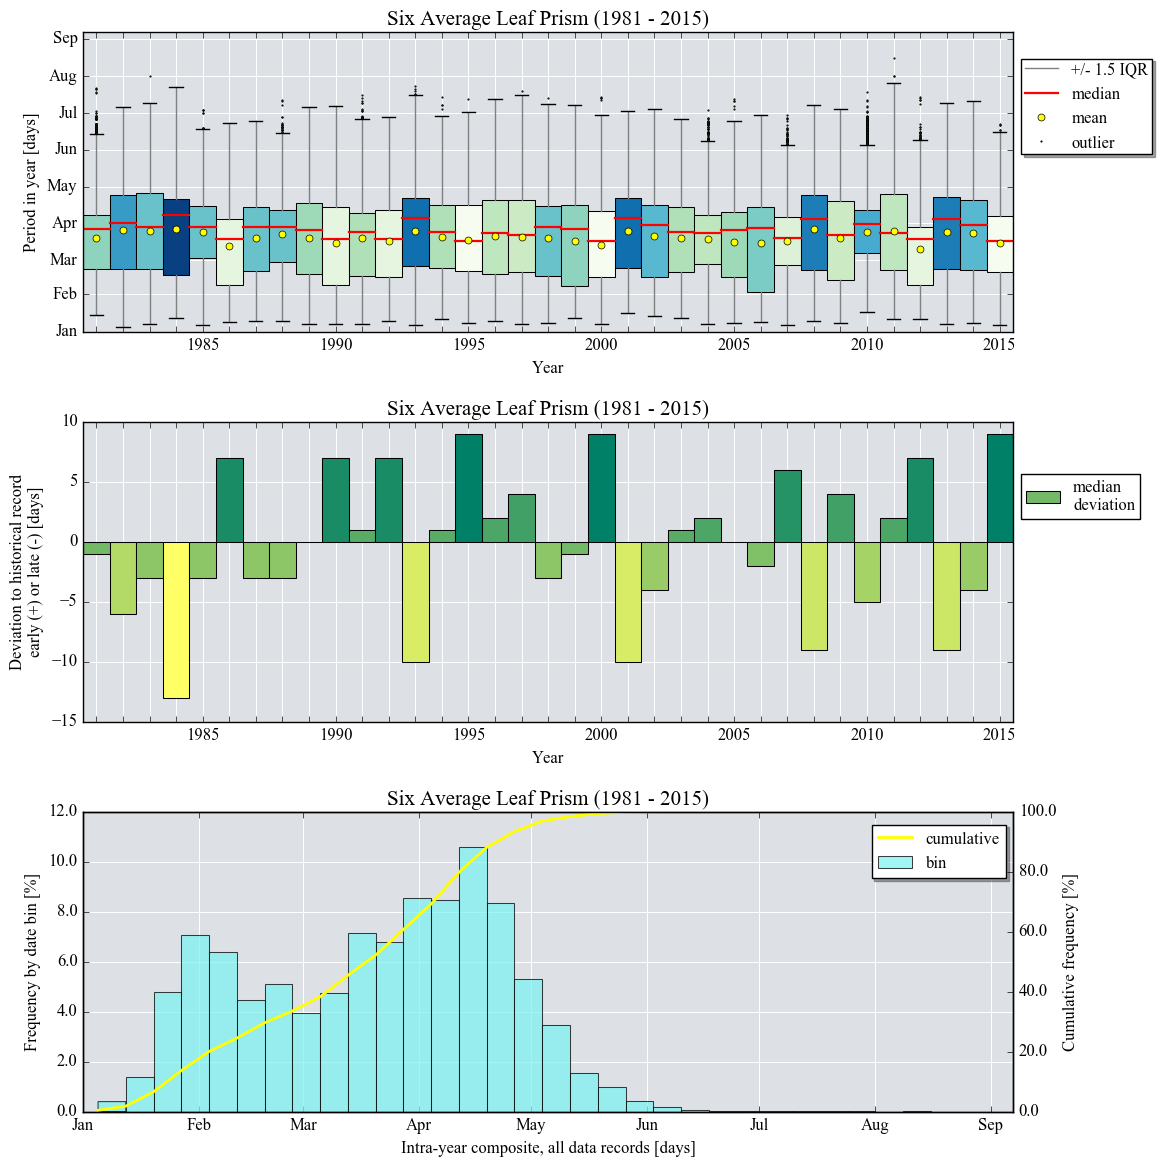

In [10]:
# ********************************************
#  Real-time - plot processing and generation
# ********************************************

# Real-time processing of files using load data set

tasklist.append('Real-time plot generation')
tstamp.append(timer())

# Process time periods, simplify labels
time_var = nc_file.variables['time']
dtime = netCDF4.num2date(time_var[:],time_var.units)
dt_year = [d.year for d in dtime] 
ind = np.arange(1,len(dt_year)+1)
minyear = min(dt_year)
maxyear = max(dt_year)
xlabelsnew = []
for i in dt_year:
    if i % 5 == 0:
        xlabelsnew.append(i)
    else:
        xlabelsnew.append('')

# create subplots
plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter("%b")

# calculate annual medians and deviations from medians
median_year = [np.median(d) for d in d_mod]
median_all = np.median((data[~data.mask]))
diff_median_year = median_all - median_year
errbar_med = np.transpose([median_year[i]-(np.min(d), np.max(d)-median_year[i]) for i,d in enumerate(d_mod)])
    
# plt 1: box plot - time series
xlabeltext = 'Year'
ylabeltext = 'Period in year [days]'
title = '%s (%d - %d)' % (str(key[3]).replace("_"," ").title(), minyear, maxyear)
clr = cm.GnBu(palette_values(np.multiply(median_year,1.0), 0.05))
makeboxplot(ax1, d_mod)

# plt 2: bar plot  - residual time series (median)
xlabeltext = 'Year'
#ylabeltext = 'Advanced (+) or lagged (-),\nin number of days'
ylabeltext = 'Deviation to historical record\nearly (+) or late (-) [days]'
title = '%s (%d - %d)' % (str(key[3]).replace("_"," ").title(), minyear, maxyear)
clr = cm.summer(palette_values(np.multiply(diff_median_year,-1.0), 0.05)) 
makebarplot_resid(ax2, ind, diff_median_year)

# plt 3: histogram  - frequency
xlabeltext = 'Intra-year composite, all data records [days]'
ylabeltext = 'Frequency by date bin [%]'
title = '%s (%d - %d)' % (str(key[3]).replace("_"," ").title(), minyear, maxyear)
histogram_freq(ax3, 30)
  
# adjust subplot orientation
plt.subplots_adjust(left=None, bottom=0.0, right=None, top=None, wspace=None, hspace=0.30)
ax1.yaxis.set_major_locator(months)
ax1.yaxis.set_major_formatter(monthsFmt)

# save figure if needed, else comment out
#plt.savefig(fpath + 'si-x-average_leaf_prism_BCB_test.png', format='png', dpi=450,bbox_inches='tight', pad_inches=0.05)

/Users/twellman/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:107: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


('Calc check: sum bin (discrete) probability [%]:', 99.99999999999217)


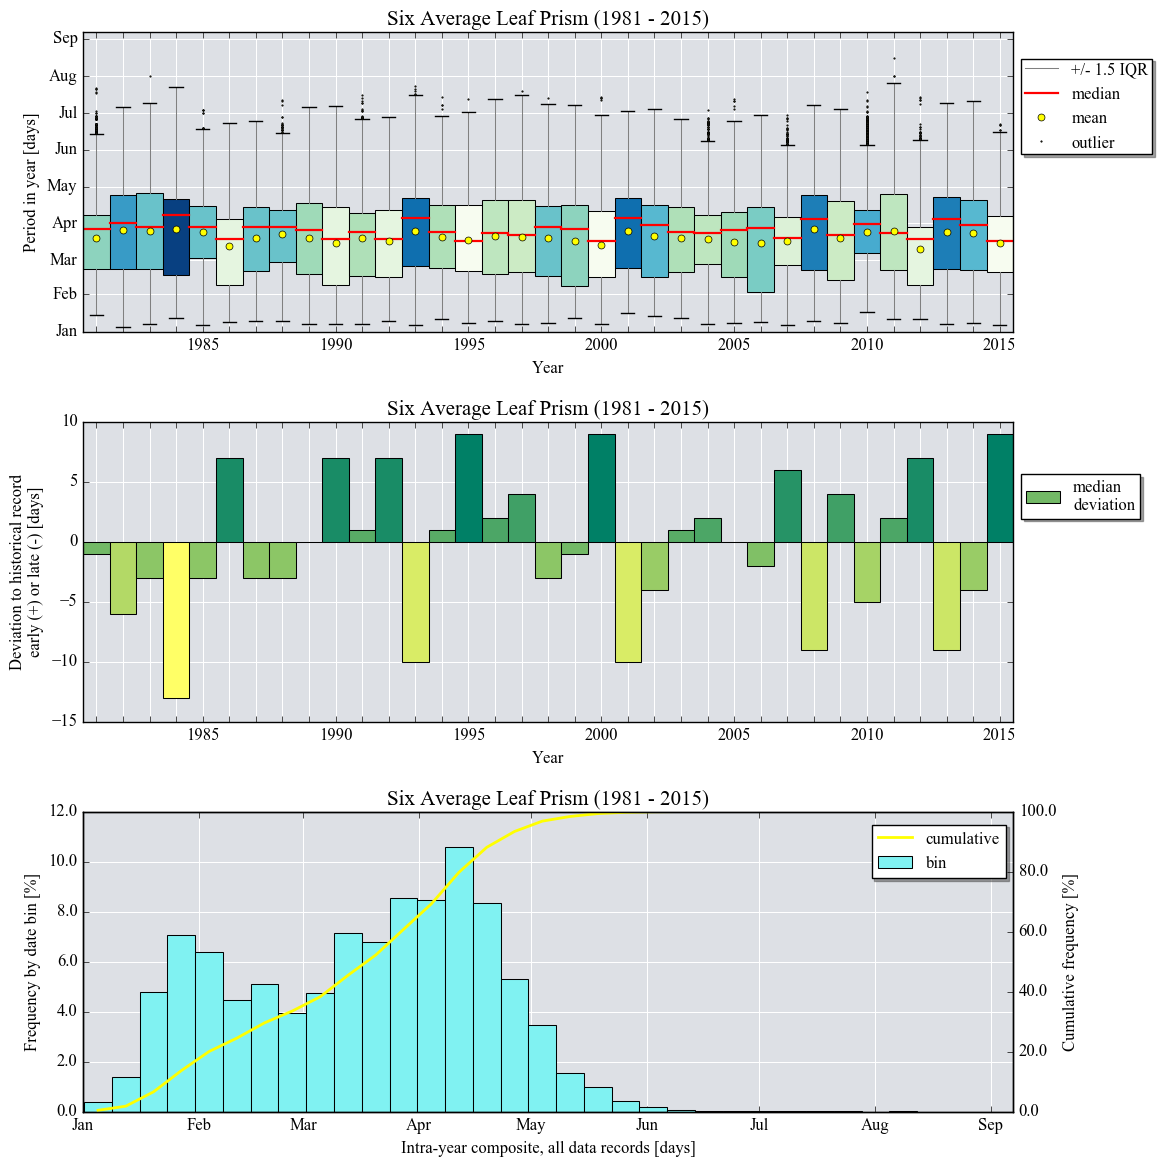

In [11]:

# *********************************
#   Pre-processed plot generation
# *********************************

# plots use preprocessed information (plot specification dictionaries) 
# a work in progress ....

tasklist.append('Pre-processed plot generation')
tstamp.append(timer())

# subplot configuration
#plt.rcParams.update({'font.family': "Times New Roman",'font.size': 12})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
#plt.ioff()
#months = mdates.MonthLocator()
#monthsFmt = mdates.DateFormatter("%b")

# plt 1: box plot - time series
makeboxplot_preprocess(ax1, stats['box_plot'], stats['plot_specs'])

# plt 2: bar plot  - residual time series (median) 
makebarplot_resid_preprocess(ax2, stats['plot_specs']['ind'], stats['bar_plot']['dev_yr'], stats['plot_specs'])

# plt 3: histogram  - frequency
histogram_freq_preprocess(ax3, stats['hist_plot'],stats['plot_specs'])
  
# adjust subplot orientation
plt.subplots_adjust(left=None, bottom=0.0, right=None, top=None, wspace=None, hspace=0.30)

In [12]:
# simple timing outputs
tstamp.append(timer())
for i in range(len(tstamp)-1):
    print('Task '+ str(i+1) + ': ' + tasklist[i] + ' | Runtime [secs]: '+ str(round(tstamp[i+1]-tstamp[i],3)))



Task 1: Load netcdf data, slice data, patch for data masking | Runtime [secs]: 0.601
Task 2: Generate real-time python plotting definitions | Runtime [secs]: 0.129
Task 3: Generate preprocessed python plotting definitions | Runtime [secs]: 0.069
Task 4: Generate key-value dictionary of preprocessed plot information | Runtime [secs]: 0.0
Task 5: Pre-process plot info + plot calcs | Runtime [secs]: 1.089
Task 6: display key-value dictionary | Runtime [secs]: 0.11
Task 7: Real-time plot generation | Runtime [secs]: 2.776
Task 8: Pre-processed plot generation | Runtime [secs]: 1.756
